In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from rich.progress import Progress, BarColumn, TimeRemainingColumn

In [2]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

N = 10_000
D = 2

x = torch.linspace(-2, 2, 100)
x1, x2 = torch.meshgrid(x, x, indexing='ij')
x1 = x1.flatten()
x2 = x2.flatten()
X = torch.stack([x1, x2], dim=1).to(device)
true_w = torch.tensor([2.0, -1.0], device=device)
true_b = 1.0
probs = torch.sigmoid(X @ true_w + true_b)
y = torch.bernoulli(probs)

Using device: cuda


In [3]:
class BayesianLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.w = nn.Parameter(torch.randn(input_dim, device=device) * 0.1)
        self.b = nn.Parameter(torch.randn(1, device=device) * 0.1)

    def forward(self, x):
        return torch.sigmoid(x @ self.w + self.b)

class SGLD(optim.Optimizer):
    def __init__(self, params, lr=1e-2, weight_decay=1e-4):
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(SGLD, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, dataset_size):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                scale = dataset_size / p.grad.shape[0]
                grad = scale * p.grad + group['weight_decay'] * p
                p.add_(grad, alpha=-group['lr'])
                noise = torch.randn_like(p, device=p.device) * (2 * group['lr']) ** 0.5
                p.add_(noise)

In [4]:
num_epochs = 2000
batch_size = 256
lr = 1e-4
burn_in = 1000

model = BayesianLogisticRegression(D).to(device)
optimizer = SGLD(model.parameters(), lr=lr)

In [5]:
posterior_samples = []

with Progress(
    "[progress.description]{task.description}",
    BarColumn(),
    "[progress.percentage]{task.percentage:>3.0f}%",
    "[bold blue]Loss: {task.fields[loss]:.6f}",
    TimeRemainingColumn(),
) as progress:
    task = progress.add_task("Training...", total=num_epochs, loss=0.0)

    for epoch in range(num_epochs):
        indices = torch.randperm(N, device=device)
        epoch_loss = 0.0
        batch_count = 0

        for i in range(0, N, batch_size):
            batch_indices = indices[i:i + batch_size]
            X_batch, y_batch = X[batch_indices], y[batch_indices]
            y_pred = model(X_batch)
            loss = nn.BCELoss()(y_pred, y_batch)
            epoch_loss += loss.item()
            batch_count += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step(dataset_size=N)
        
        if epoch >= burn_in and epoch % 5 == 0:
            posterior_samples.append(torch.cat([
                model.w.clone().detach(),
                model.b.clone().detach(),
            ]))

        progress.update(task, advance=1, loss=epoch_loss / batch_count)

posterior_samples = torch.stack(posterior_samples).cpu().numpy()

Output()

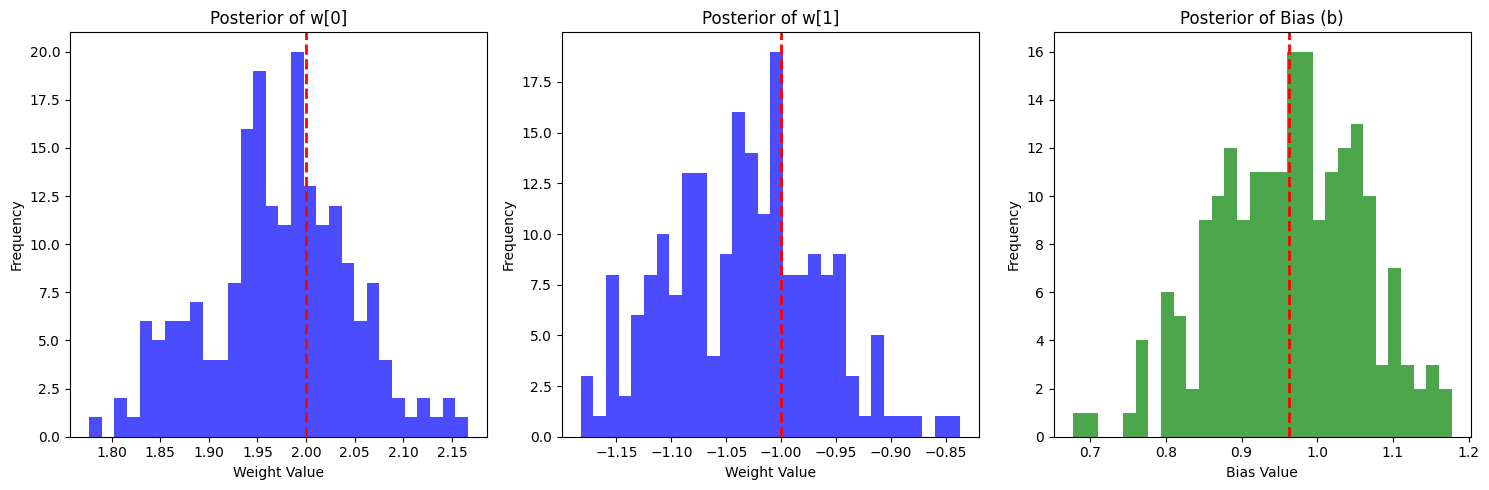

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(D):
    axes[i].hist(posterior_samples[:, i], bins=30, alpha=0.7, color='blue')
    axes[i].axvline(true_w[i].cpu().item(), color='red', linestyle='dashed', linewidth=2)
    axes[i].set_title(f"Posterior of w[{i}]")
    axes[i].set_xlabel("Weight Value")
    axes[i].set_ylabel("Frequency")

axes[2].hist(posterior_samples[:, D], bins=30, alpha=0.7, color='green')
axes[2].axvline(model.b.cpu().item(), color='red', linestyle='dashed', linewidth=2)
axes[2].set_title("Posterior of Bias (b)")
axes[2].set_xlabel("Bias Value")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig('bayesian_posterior_with_bias.png')
plt.show()